In [4]:
from __future__ import print_function
import imageio, keras
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import tensorflow as tf
from keras import backend as K
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"
GPU=True
CPU=False
num_cores = 4

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
session = tf.Session(config=config)
K.set_session(session)
%matplotlib inline

In [5]:
from keras.datasets import cifar10

num_classes=10

img_rows, img_cols = 32, 32
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

train_dataset shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
# Copy data to 3 channels and resample to get 56x56 images
# VGG needs atleast 48x48, so resample
# Center and resample diffraction array to desired pixel spacing
from scipy.ndimage.interpolation import zoom

def resample(diff3D, Nx, Ny): 
    nx, ny, nz = diff3D.shape
    diff3D=zoom(diff3D, (float(Nx)/nx,float(Ny)/ny, 1), order=1)
    return diff3D


from tqdm import tqdm
def copy3channels(input_data):
    dims = input_data.shape
    # dataset3 = np.zeros((dims[0],28,28,3),float)
    # for i in tqdm(range(dims[0])):
    #    dataset3[i,:,:,0], dataset3[i,:,:,1], dataset3[i,:,:,2] = input_data[i,:,:,0], input_data[i,:,:,0], input_data[i,:,:,0]
    data=[]
    for i in tqdm(range(dims[0])):
        tmp=resample(input_data[i,:,:,:],64,64)
        data.append(tmp)
    return np.array(data)

In [9]:
x_train_prepro = copy3channels(x_train)
x_test_prepro = copy3channels(x_test)



  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 77/50000 [00:00<01:05, 760.17it/s]

  0%|          | 152/50000 [00:00<01:06, 754.86it/s]

  0%|          | 227/50000 [00:00<01:06, 752.79it/s]

  1%|          | 302/50000 [00:00<01:06, 751.55it/s]

  1%|          | 375/50000 [00:00<01:06, 743.84it/s]

  1%|          | 450/50000 [00:00<01:06, 745.10it/s]

  1%|          | 525/50000 [00:00<01:06, 745.95it/s]

  1%|          | 600/50000 [00:00<01:06, 746.83it/s]

  1%|▏         | 675/50000 [00:00<01:06, 746.84it/s]

  2%|▏         | 750/50000 [00:01<01:05, 746.88it/s]

  2%|▏         | 825/50000 [00:01<01:05, 746.72it/s]

  2%|▏         | 900/50000 [00:01<01:05, 746.68it/s]

  2%|▏         | 976/50000 [00:01<01:05, 748.03it/s]

  2%|▏         | 1051/50000 [00:01<01:05, 748.26it/s]

  2%|▏         | 1127/50000 [00:01<01:05, 749.26it/s]

  2%|▏         | 1202/50000 [00:01<01:05, 748.69it/s]

  3%|▎         | 1277/50000 [00:01<01:05, 748.88it/s]

  3%|▎         | 1352/50000 [00:01

 20%|██        | 10061/50000 [00:13<00:53, 748.61it/s]

 20%|██        | 10137/50000 [00:13<00:53, 749.42it/s]

 20%|██        | 10212/50000 [00:13<00:53, 747.68it/s]

 21%|██        | 10287/50000 [00:13<00:53, 747.98it/s]

 21%|██        | 10362/50000 [00:13<00:52, 748.17it/s]

 21%|██        | 10437/50000 [00:13<00:53, 745.72it/s]

 21%|██        | 10512/50000 [00:14<00:52, 746.37it/s]

 21%|██        | 10588/50000 [00:14<00:52, 747.61it/s]

 21%|██▏       | 10663/50000 [00:14<00:52, 748.33it/s]

 21%|██▏       | 10739/50000 [00:14<00:52, 748.87it/s]

 22%|██▏       | 10815/50000 [00:14<00:52, 749.59it/s]

 22%|██▏       | 10891/50000 [00:14<00:52, 749.86it/s]

 22%|██▏       | 10966/50000 [00:14<00:52, 749.53it/s]

 22%|██▏       | 11041/50000 [00:14<00:51, 749.63it/s]

 22%|██▏       | 11116/50000 [00:14<00:51, 748.99it/s]

 22%|██▏       | 11192/50000 [00:14<00:51, 749.36it/s]

 23%|██▎       | 11267/50000 [00:15<00:51, 748.17it/s]

 23%|██▎       | 11342/50000 [00:15<00:51, 748.2

 40%|████      | 20039/50000 [00:26<00:40, 745.80it/s]

 40%|████      | 20114/50000 [00:26<00:40, 745.50it/s]

 40%|████      | 20189/50000 [00:27<00:40, 739.15it/s]

 41%|████      | 20264/50000 [00:27<00:40, 741.69it/s]

 41%|████      | 20339/50000 [00:27<00:39, 742.81it/s]

 41%|████      | 20414/50000 [00:27<00:39, 743.27it/s]

 41%|████      | 20489/50000 [00:27<00:39, 744.58it/s]

 41%|████      | 20564/50000 [00:27<00:39, 745.18it/s]

 41%|████▏     | 20639/50000 [00:27<00:39, 745.20it/s]

 41%|████▏     | 20714/50000 [00:27<00:39, 743.77it/s]

 42%|████▏     | 20789/50000 [00:27<00:39, 743.03it/s]

 42%|████▏     | 20864/50000 [00:27<00:39, 742.71it/s]

 42%|████▏     | 20939/50000 [00:28<00:39, 741.45it/s]

 42%|████▏     | 21014/50000 [00:28<00:39, 743.07it/s]

 42%|████▏     | 21089/50000 [00:28<00:38, 743.39it/s]

 42%|████▏     | 21164/50000 [00:28<00:38, 744.09it/s]

 42%|████▏     | 21239/50000 [00:28<00:38, 743.02it/s]

 43%|████▎     | 21314/50000 [00:28<00:38, 744.1

 60%|██████    | 30008/50000 [00:40<00:26, 747.88it/s]

 60%|██████    | 30084/50000 [00:40<00:26, 748.69it/s]

 60%|██████    | 30160/50000 [00:40<00:26, 749.67it/s]

 60%|██████    | 30236/50000 [00:40<00:26, 750.20it/s]

 61%|██████    | 30312/50000 [00:40<00:26, 750.97it/s]

 61%|██████    | 30388/50000 [00:40<00:26, 751.48it/s]

 61%|██████    | 30464/50000 [00:40<00:26, 748.56it/s]

 61%|██████    | 30539/50000 [00:40<00:26, 743.42it/s]

 61%|██████    | 30614/50000 [00:40<00:26, 744.83it/s]

 61%|██████▏   | 30689/50000 [00:41<00:25, 746.04it/s]

 62%|██████▏   | 30765/50000 [00:41<00:25, 747.37it/s]

 62%|██████▏   | 30840/50000 [00:41<00:25, 746.86it/s]

 62%|██████▏   | 30916/50000 [00:41<00:25, 747.95it/s]

 62%|██████▏   | 30991/50000 [00:41<00:25, 747.55it/s]

 62%|██████▏   | 31067/50000 [00:41<00:25, 748.41it/s]

 62%|██████▏   | 31143/50000 [00:41<00:25, 749.08it/s]

 62%|██████▏   | 31218/50000 [00:41<00:25, 749.35it/s]

 63%|██████▎   | 31293/50000 [00:41<00:24, 749.1

 80%|███████▉  | 39944/50000 [00:53<00:13, 746.73it/s]

 80%|████████  | 40019/50000 [00:53<00:13, 747.43it/s]

 80%|████████  | 40094/50000 [00:53<00:13, 747.69it/s]

 80%|████████  | 40169/50000 [00:53<00:13, 747.70it/s]

 80%|████████  | 40244/50000 [00:53<00:13, 747.60it/s]

 81%|████████  | 40319/50000 [00:53<00:12, 748.28it/s]

 81%|████████  | 40394/50000 [00:54<00:12, 748.37it/s]

 81%|████████  | 40470/50000 [00:54<00:12, 749.20it/s]

 81%|████████  | 40546/50000 [00:54<00:12, 749.94it/s]

 81%|████████  | 40621/50000 [00:54<00:12, 748.39it/s]

 81%|████████▏ | 40697/50000 [00:54<00:12, 749.15it/s]

 82%|████████▏ | 40772/50000 [00:54<00:12, 748.14it/s]

 82%|████████▏ | 40848/50000 [00:54<00:12, 748.84it/s]

 82%|████████▏ | 40924/50000 [00:54<00:12, 749.39it/s]

 82%|████████▏ | 40999/50000 [00:54<00:12, 748.88it/s]

 82%|████████▏ | 41075/50000 [00:54<00:11, 749.45it/s]

 82%|████████▏ | 41150/50000 [00:55<00:11, 749.04it/s]

 82%|████████▏ | 41226/50000 [00:55<00:11, 750.0

100%|█████████▉| 49876/50000 [01:06<00:00, 750.87it/s]

100%|██████████| 50000/50000 [01:06<00:00, 747.59it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  1%|          | 79/10000 [00:00<00:12, 780.81it/s]

  2%|▏         | 156/10000 [00:00<00:12, 776.16it/s]

  2%|▏         | 233/10000 [00:00<00:12, 773.38it/s]

  3%|▎         | 310/10000 [00:00<00:12, 771.90it/s]

  4%|▍         | 387/10000 [00:00<00:12, 770.49it/s]

  5%|▍         | 464/10000 [00:00<00:12, 768.94it/s]

  5%|▌         | 541/10000 [00:00<00:12, 768.73it/s]

  6%|▌         | 618/10000 [00:00<00:12, 768.59it/s]

  7%|▋         | 695/10000 [00:00<00:12, 768.78it/s]

  8%|▊         | 773/10000 [00:01<00:11, 769.25it/s]

  9%|▊         | 851/10000 [00:01<00:11, 769.67it/s]

  9%|▉         | 928/10000 [00:01<00:11, 769.40it/s]

 10%|█         | 1005/10000 [00:01<00:11, 766.83it/s]

 11%|█         | 1082/10000 [00:01<00:11, 765.15it/s]

 12%|█▏        | 1159/10000 [00:01<00:11, 766.13it/s]

 12%|█▏        | 1236/10000 [00:

In [10]:
x_train_prepro.shape

(50000, 64, 64, 3)

In [16]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# K.clear_session()

from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras import backend as K
from keras.utils import to_categorical

import keras
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.models import Model, load_model
from keras.layers import GlobalMaxPooling2D
from keras.utils import np_utils
from keras import regularizers

weight_decay = 0.0005

#base_model.layers.pop() 
#Pop out the current logistic layer
base_model = VGG16(input_shape=(64, 64, 3), weights='imagenet', include_top=False)
for layers in base_model.layers:
    layers.trainable = False

tmp = Flatten()(base_model.output)
#Add a fully connected layer
tmp = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc1')(tmp)
tmp = BatchNormalization()(tmp)
tmp = Dropout(0.5)(tmp)
tmp = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc2')(tmp)
tmp = BatchNormalization()(tmp)
tmp = Dropout(0.5)(tmp)
predictions = Dense(10, activation='softmax')(tmp)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
    
sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#Save model every epoch
# checkpoints=keras.callbacks.ModelCheckpoint('vgg_weights/weights.{epoch:02d}.hdf5', monitor='val_loss', 
                                # verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# print (model.summary())


# history=model.fit(x_train_prepro, y_train_onehot,
                #np_utils.to_categorical(labels,n_labels),  
                # batch_size=batch_size, epochs=epochs, verbose=1, validation_split = 0.25, callbacks=[checkpoints])

In [17]:
## Callback for loss logging per epoch
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
batch_size=256
epochs=200

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_vgg16():
    
    history = LossHistory()
    model.fit(x_train_prepro, y_train_onehot, batch_size=batch_size, epochs=epochs,
              validation_split=0.15, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test_prepro, verbose=0)
    return predictions, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [18]:
predictions, history = run_vgg16()
print(model.summary())

Train on 42500 samples, validate on 7500 samples
Epoch 1/200
42500/42500 [==============================] - 20s 476us/step - loss: 5.1458 - accuracy: 0.5312 - val_loss: 5.0098 - val_accuracy: 0.5025
Epoch 2/200
42500/42500 [==============================] - 18s 433us/step - loss: 4.9151 - accuracy: 0.5786 - val_loss: 8.4478 - val_accuracy: 0.4075
Epoch 3/200
42500/42500 [==============================] - 18s 435us/step - loss: 4.9381 - accuracy: 0.5894 - val_loss: 5.7450 - val_accuracy: 0.5079
Epoch 4/200
42500/42500 [==============================] - 18s 434us/step - loss: 5.0676 - accuracy: 0.5848 - val_loss: 7.9095 - val_accuracy: 0.3889
Epoch 5/200
42500/42500 [==============================] - 18s 434us/step - loss: 5.0586 - accuracy: 0.5900 - val_loss: 6.7946 - val_accuracy: 0.5008
Epoch 6/200
42500/42500 [==============================] - 18s 434us/step - loss: 4.9639 - accuracy: 0.5994 - val_loss: 7.8017 - val_accuracy: 0.4320
Epoch 7/200
42500/42500 [==========================

Epoch 55/200
42500/42500 [==============================] - 19s 435us/step - loss: 3.1651 - accuracy: 0.6916 - val_loss: 3.3143 - val_accuracy: 0.6520
Epoch 56/200
42500/42500 [==============================] - 18s 435us/step - loss: 3.0845 - accuracy: 0.6968 - val_loss: 3.5320 - val_accuracy: 0.6387
Epoch 57/200
42500/42500 [==============================] - 18s 434us/step - loss: 3.1908 - accuracy: 0.6914 - val_loss: 3.7740 - val_accuracy: 0.5484
Epoch 58/200
42500/42500 [==============================] - 18s 435us/step - loss: 3.4108 - accuracy: 0.6736 - val_loss: 3.8410 - val_accuracy: 0.5916
Epoch 59/200
42500/42500 [==============================] - 18s 434us/step - loss: 3.4311 - accuracy: 0.6709 - val_loss: 5.0764 - val_accuracy: 0.5511
Epoch 60/200
42500/42500 [==============================] - 18s 434us/step - loss: 3.5300 - accuracy: 0.6679 - val_loss: 3.6453 - val_accuracy: 0.6407
Epoch 61/200
42500/42500 [==============================] - 19s 436us/step - loss: 3.3605 - ac

42500/42500 [==============================] - 18s 433us/step - loss: 2.3236 - accuracy: 0.7409 - val_loss: 2.4140 - val_accuracy: 0.7163
Epoch 110/200
42500/42500 [==============================] - 18s 433us/step - loss: 2.2466 - accuracy: 0.7530 - val_loss: 2.4097 - val_accuracy: 0.7121
Epoch 111/200
42500/42500 [==============================] - 18s 434us/step - loss: 2.2580 - accuracy: 0.7471 - val_loss: 2.3604 - val_accuracy: 0.7296
Epoch 112/200
42500/42500 [==============================] - 18s 434us/step - loss: 2.1848 - accuracy: 0.7588 - val_loss: 2.3677 - val_accuracy: 0.7201
Epoch 113/200
42500/42500 [==============================] - 19s 435us/step - loss: 2.1980 - accuracy: 0.7537 - val_loss: 2.5670 - val_accuracy: 0.6848
Epoch 114/200
42500/42500 [==============================] - 19s 435us/step - loss: 2.2143 - accuracy: 0.7544 - val_loss: 2.3523 - val_accuracy: 0.7181
Epoch 115/200
42500/42500 [==============================] - 18s 434us/step - loss: 2.1704 - accuracy:

Epoch 163/200
42500/42500 [==============================] - 19s 438us/step - loss: 1.9305 - accuracy: 0.7538 - val_loss: 2.0760 - val_accuracy: 0.7197
Epoch 164/200
42500/42500 [==============================] - 19s 439us/step - loss: 1.9930 - accuracy: 0.7428 - val_loss: 2.0895 - val_accuracy: 0.7248
Epoch 165/200
42500/42500 [==============================] - 19s 441us/step - loss: 1.9331 - accuracy: 0.7553 - val_loss: 2.1159 - val_accuracy: 0.7175
Epoch 166/200
42500/42500 [==============================] - 19s 441us/step - loss: 2.0283 - accuracy: 0.7343 - val_loss: 2.1183 - val_accuracy: 0.7279
Epoch 167/200
42500/42500 [==============================] - 19s 438us/step - loss: 1.9472 - accuracy: 0.7528 - val_loss: 2.0575 - val_accuracy: 0.7312
Epoch 168/200
42500/42500 [==============================] - 19s 439us/step - loss: 1.8786 - accuracy: 0.7656 - val_loss: 2.1620 - val_accuracy: 0.6940
Epoch 169/200
42500/42500 [==============================] - 19s 438us/step - loss: 1.89

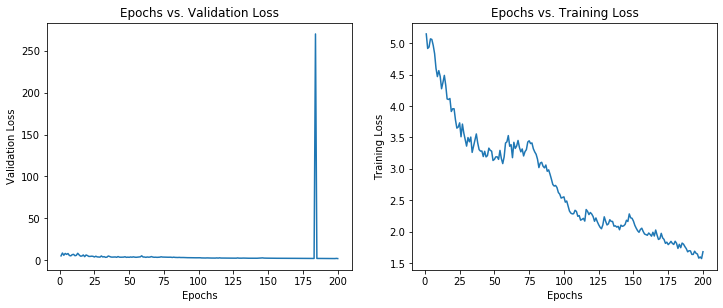

In [19]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,201), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,201), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

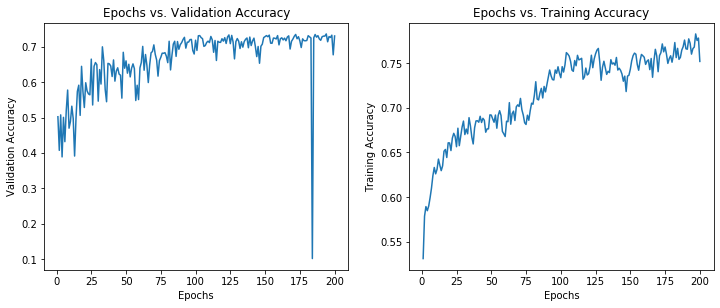

In [20]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,201), history.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,201), history.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [ ]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

In [ ]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test_prepro[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test_prepro[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))